In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFilter
import os
#import cv2
import random
import tensorflow as tf

from tensorflow import keras

In [2]:
from imutils import paths
import face_recognition
import pickle
import cv2
import os

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12043937377615981067
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4841275392
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14995157696010632469
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [4]:
# Загружаем файл каскада Хаарта
faceCascade = cv2.CascadeClassifier(r"D:\TeachMeSkills\DZ\dz22\haarcascade_frontalface_alt2.xml")

In [5]:
imagePaths =r'D:\TeachMeSkills\DZ\dz27\wiki_crop'

In [6]:
from tqdm import tqdm

In [7]:
df = pd.DataFrame(columns=['link', 'age']) ### Создаем пустой Dataframe с колонками Link - ссылка на файл, Age - Возраст

for dirname, _,filenames in tqdm(os.walk(imagePaths)):
    for filename in filenames:
        #формируем ссылку на изображение
        link = os.path.join(dirname, filename)
        
         #### Распознавание лица с помощью каскадов Хаара
        img = cv2.imread(link)
####        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img.shape[-1]==3:
            img_new = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img_new = img
        
        faces = faceCascade.detectMultiScale(img_new,
                                     scaleFactor=1.1,
                                     minNeighbors=5,
                                     minSize=(60, 60),
                                     flags=cv2.CASCADE_SCALE_IMAGE)
        if len(faces)==1:
            end = filename[-8:-4]
            start = filename.split('_')[1].split('-')[0]
            age = int(end)-int(start)
            x, y, w, h = faces[0]
            face_selected = img[y:y+h, x:x+h]
            link2 = os.path.join(r'D:\TeachMeSkills\DZ\dz27\wiki_crop\new', filename)
            cv2.imwrite(link2,face_selected)             ### Сохраним в файл с таким же именем, но в новую папку.\n",
            df.loc[len(df.index )] = [link2,age]
df.drop_duplicates (subset=['link'])            

102it [26:32, 15.61s/it] 


link  age
0      D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1004920...   67
1      D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1011060...   27
2      D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1012640...   46
3      D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1013900...   43
4      D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1016640...   48
...                                                  ...  ...
30616  D:\TeachMeSkills\DZ\dz27\wiki_crop\new\9598699...   79
30617  D:\TeachMeSkills\DZ\dz27\wiki_crop\new\961599_...   59
30618  D:\TeachMeSkills\DZ\dz27\wiki_crop\new\9799_19...   52
30619  D:\TeachMeSkills\DZ\dz27\wiki_crop\new\981199_...   52
30620  D:\TeachMeSkills\DZ\dz27\wiki_crop\new\995799_...   33

[30621 rows x 2 columns]

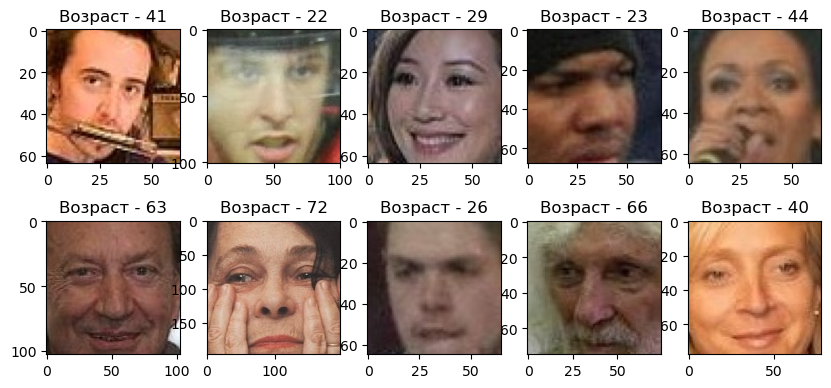

In [8]:
idx = np.random.randint (0,len(df),10)
plt.figure(figsize=(10,12))
for idx in enumerate(idx):
        plt.subplot (5,5,idx[0]+1)
        link = df.iloc[idx[1]]
        image = plt.imread(link[0])
        title = 'Возраст - ' + str(link[1])
        plt.title (title)
        plt.imshow(image, cmap='gray')

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,GlobalMaxPool2D, Conv2D, MaxPooling2D,Activation, Flatten, CategoryEncoding,Dropout, BatchNormalization, AveragePooling2D
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError

In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=34)

In [11]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [12]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="training",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="validation",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="link",
y_col="age",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

Found 30987 validated image filenames.
Found 13280 validated image filenames.
Found 11067 validated image filenames.


Модель №1

In [13]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(GlobalMaxPool2D())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer = Adam(),loss="mse", metrics=["mae"])


In [14]:
checkpoint_cb_conv = ModelCheckpoint("Model.h5",
                                         monitor = 'val_mae',
                                         save_best_only=True)
    
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [16]:
history = model.fit(train_generator, validation_data=valid_generator,callbacks=[checkpoint_cb_conv,lr_scheduler], epochs=20)

Epoch 1/20
969/969 [==============================] - 132s 136ms/step - loss: 283.4417 - mae: 12.7374 - val_loss: 499.4435 - val_mae: 11.1787 - lr: 0.0010
Epoch 2/20
969/969 [==============================] - 37s 39ms/step - loss: 214.4937 - mae: 10.6396 - val_loss: 456.3046 - val_mae: 9.6518 - lr: 0.0010
Epoch 3/20
969/969 [==============================] - 45s 46ms/step - loss: 180.0778 - mae: 9.5833 - val_loss: 451.0252 - val_mae: 9.9620 - lr: 0.0010
Epoch 4/20
969/969 [==============================] - 41s 43ms/step - loss: 163.5724 - mae: 9.0870 - val_loss: 433.4906 - val_mae: 9.1393 - lr: 0.0010
Epoch 5/20
969/969 [==============================] - 41s 42ms/step - loss: 148.6881 - mae: 8.6669 - val_loss: 425.6186 - val_mae: 8.7107 - lr: 0.0010
Epoch 6/20
969/969 [==============================] - 42s 43ms/step - loss: 131.2618 - mae: 8.2860 - val_loss: 451.9371 - val_mae: 9.5253 - lr: 0.0010
Epoch 7/20
969/969 [==============================] - 42s 43ms/step - loss: 155.0807 - ma

In [17]:
model.evaluate (test_generator)

346/346 [==============================] - 14s 42ms/step - loss: 87.8458 - mae: 6.1420


[87.84581756591797, 6.141986846923828]

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

In [19]:
len(test)

11067

1/1 [==============================] - 0s 30ms/step


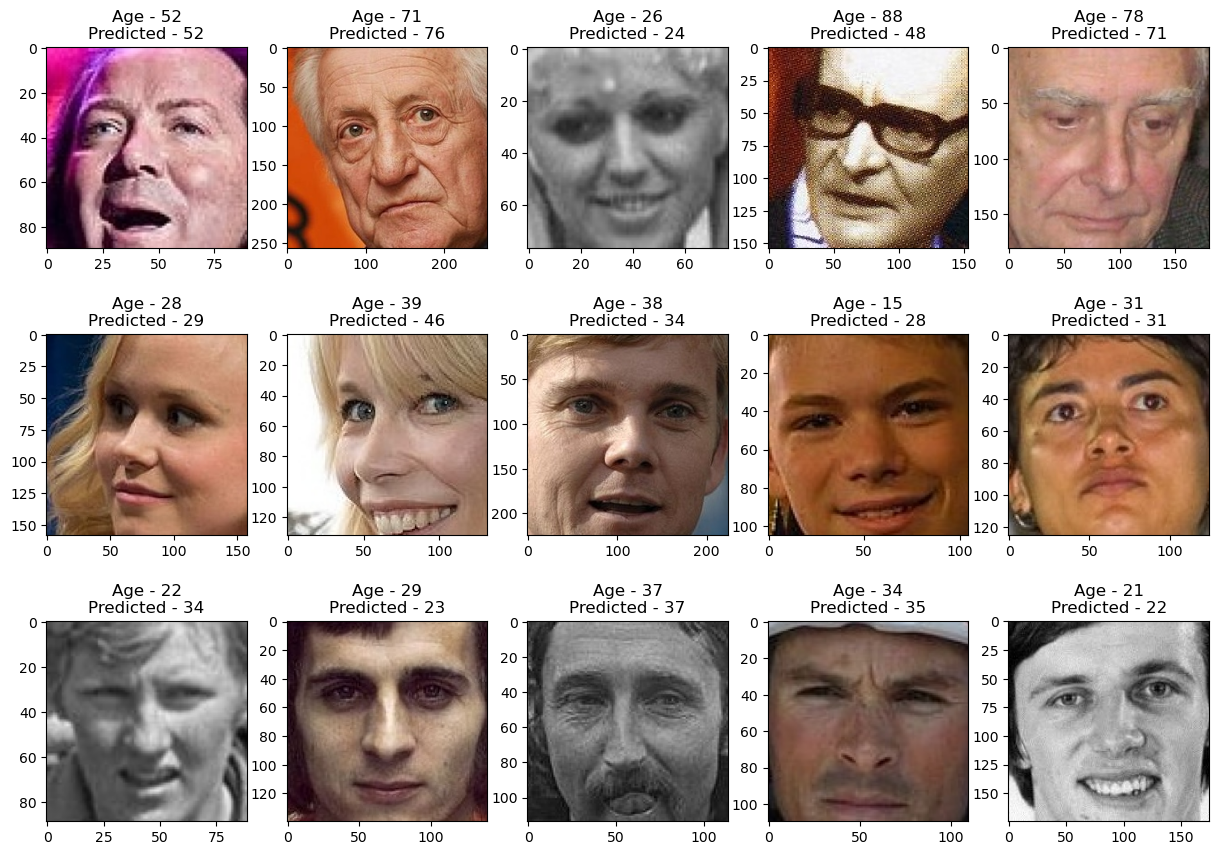

In [20]:
idx = np.random.randint (0,len(test),15)
plt.figure(figsize=(15,18))
for idx in enumerate(idx):
        plt.subplot (5,5,idx[0]+1)
        link = test.iloc[idx[1]]
        image = plt.imread(link[0])
      
        img_resized = cv2.resize (image, (64,64))/255
        img_reshaped  = img_resized.reshape (1,64,64,3)
        predict = model.predict(img_reshaped)[0][0]
    
        title = 'Age - ' + str(link[1]) + '\nPredicted - ' + str(int(predict))
        plt.title (title)
        plt.imshow(image, cmap='gray')

-------------------------------------------------------------------------

Модель №2 - ResNet50

In [21]:
from tensorflow.keras.applications import resnet
from tensorflow.keras.models import Sequential, Model

In [22]:
model_2=resnet.ResNet50(input_shape=(64,64,3),weights='imagenet', include_top=False)

In [24]:
input = model_2.layers[-1].output
x = Flatten()(input) 
x = Dense(1000, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='linear')(x)
model_2_resnet50 = Model(model_2.input, output)

In [26]:
model_2_resnet50.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
checkpoint_cb_conv = ModelCheckpoint("Model_2.h5",
                                         monitor = 'val_mae',
                                         save_best_only=True)
    
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [27]:
history_model_2 = model_2_resnet50.fit(train_generator, validation_data=valid_generator,callbacks=[checkpoint_cb_conv,lr_scheduler], epochs=20)

Epoch 1/20
969/969 [==============================] - 133s 128ms/step - loss: 180.3768 - mae: 9.4049 - val_loss: 447.3333 - val_mae: 9.1440 - lr: 5.0000e-04
Epoch 2/20
969/969 [==============================] - 123s 126ms/step - loss: 125.0529 - mae: 7.6444 - val_loss: 399.2997 - val_mae: 7.6829 - lr: 5.0000e-04
Epoch 3/20
969/969 [==============================] - 122s 126ms/step - loss: 110.0230 - mae: 7.2155 - val_loss: 497.3014 - val_mae: 11.8461 - lr: 5.0000e-04
Epoch 4/20
969/969 [==============================] - 121s 125ms/step - loss: 113.7952 - mae: 7.3838 - val_loss: 545.0231 - val_mae: 11.9408 - lr: 5.0000e-04
Epoch 5/20
969/969 [==============================] - 123s 127ms/step - loss: 74.2927 - mae: 6.1024 - val_loss: 372.3153 - val_mae: 6.5407 - lr: 1.0000e-04
Epoch 6/20
969/969 [==============================] - 124s 128ms/step - loss: 48.4160 - mae: 5.1174 - val_loss: 363.9819 - val_mae: 6.1552 - lr: 1.0000e-04
Epoch 7/20
969/969 [==============================] - 126s

In [28]:
model_2_resnet50.evaluate(test_generator)

346/346 [==============================] - 11s 32ms/step - loss: 51.2662 - mae: 4.0983


[51.266178131103516, 4.098328590393066]

1/1 [==============================] - 0s 41ms/step


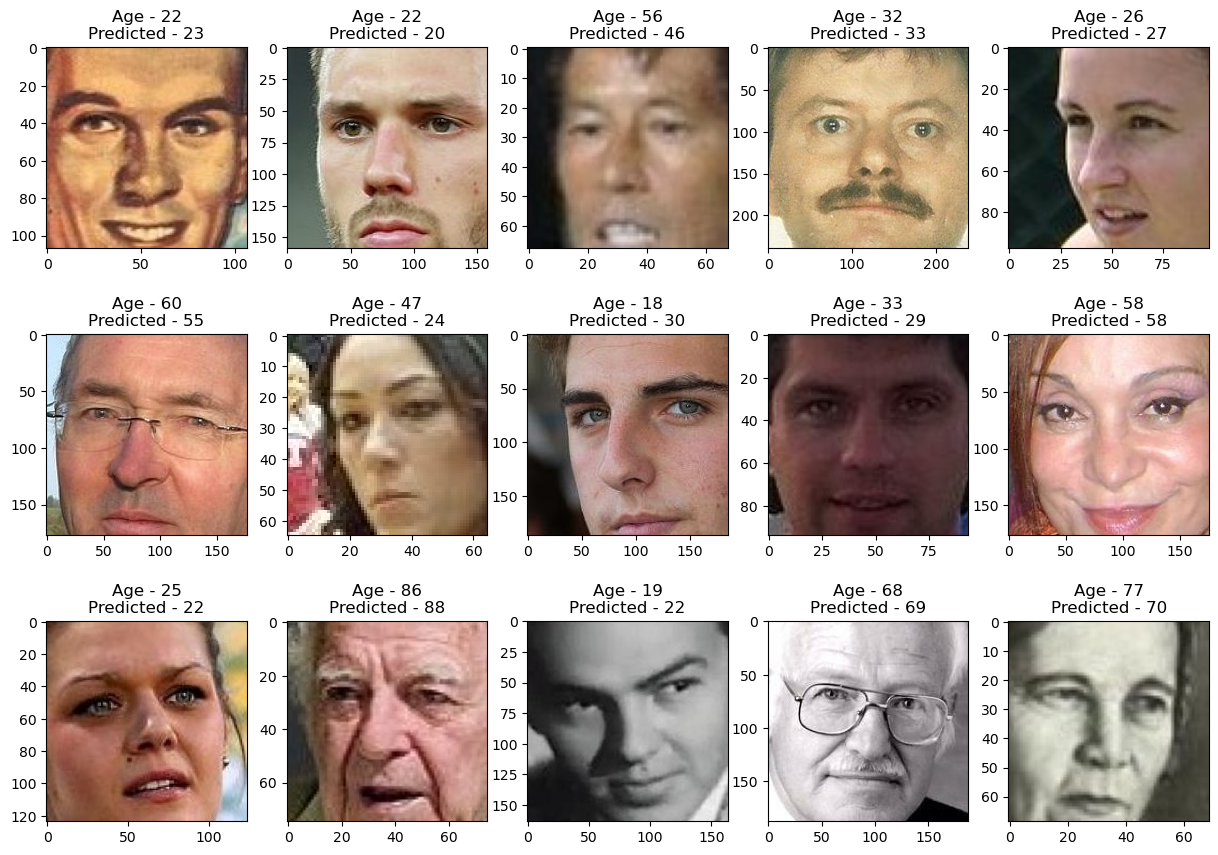

In [29]:
idx = np.random.randint (0,len(test),15)
plt.figure(figsize=(15,18))
for idx in enumerate(idx):
        plt.subplot (5,5,idx[0]+1)
        link = test.iloc[idx[1]]
        image = plt.imread(link[0])
      
        img_resized = cv2.resize (image, (64,64))/255
        img_reshaped  = img_resized.reshape (1,64,64,3)
        predict = model_2_resnet50.predict(img_reshaped)[0][0]
    
        title = 'Age - ' + str(link[1]) + '\nPredicted - ' + str(int(predict))
        plt.title (title)
        plt.imshow(image, cmap='gray')

--------------------------

Модель №3 - DenseNet121

In [30]:
from tensorflow.keras.applications import densenet

In [31]:
model_3=densenet.DenseNet121(input_shape=(64,64,3),weights='imagenet', include_top=False)

In [33]:
input = model_3.layers[-1].output
x = Flatten()(input) 
x = Dense(1000, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='linear')(x)
model_3_densenet = Model(model_3.input, output)

In [35]:
model_3_densenet.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
checkpoint_cb_conv = ModelCheckpoint("Model_3.h5",
                                         monitor = 'val_mae',
                                         save_best_only=True) 
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [36]:
history_model_3 = model_3_densenet.fit(train_generator, validation_data=valid_generator,callbacks=[checkpoint_cb_conv,lr_scheduler], epochs=20)

Epoch 1/20
969/969 [==============================] - 148s 135ms/step - loss: 169.0978 - mae: 9.0139 - val_loss: 430.5222 - val_mae: 8.4584 - lr: 5.0000e-04
Epoch 2/20
969/969 [==============================] - 126s 130ms/step - loss: 123.6715 - mae: 7.6040 - val_loss: 390.9015 - val_mae: 7.2545 - lr: 5.0000e-04
Epoch 3/20
969/969 [==============================] - 119s 123ms/step - loss: 109.2901 - mae: 7.1697 - val_loss: 410.1394 - val_mae: 7.8985 - lr: 5.0000e-04
Epoch 4/20
969/969 [==============================] - 115s 118ms/step - loss: 107.7275 - mae: 7.0479 - val_loss: 488.9119 - val_mae: 10.3960 - lr: 5.0000e-04
Epoch 5/20
969/969 [==============================] - 119s 123ms/step - loss: 88.9408 - mae: 6.3196 - val_loss: 371.3106 - val_mae: 6.2927 - lr: 1.0000e-04
Epoch 6/20
969/969 [==============================] - 119s 123ms/step - loss: 65.0224 - mae: 5.6204 - val_loss: 368.5274 - val_mae: 6.5655 - lr: 1.0000e-04
Epoch 7/20
969/969 [==============================] - 123s 

In [37]:
model_3_densenet.evaluate(test_generator)

346/346 [==============================] - 13s 38ms/step - loss: 54.0966 - mae: 4.8026


[54.096580505371094, 4.802602291107178]

1/1 [==============================] - 0s 42ms/step


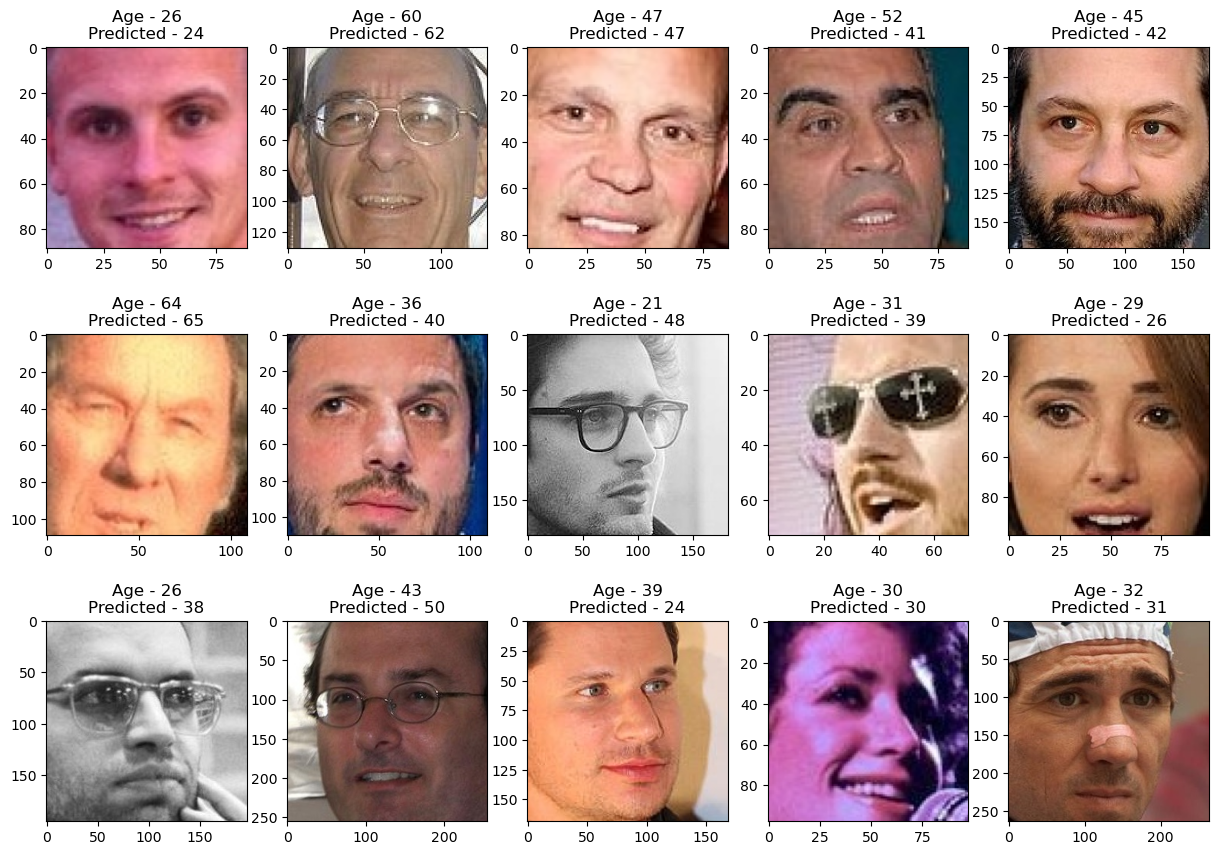

In [38]:
idx = np.random.randint (0,len(test),15)
plt.figure(figsize=(15,18))
for idx in enumerate(idx):
        plt.subplot (5,5,idx[0]+1)
        link = test.iloc[idx[1]]
        image = plt.imread(link[0])
      
        img_resized = cv2.resize (image, (64,64))/255
        img_reshaped  = img_resized.reshape (1,64,64,3)
        predict = model_3_densenet.predict(img_reshaped)[0][0]
    
        title = 'Age - ' + str(link[1]) + '\nPredicted - ' + str(int(predict))
        plt.title (title)
        plt.imshow(image, cmap='gray')

-----------------

Объединим модели

In [39]:
from tensorflow.keras.layers import Concatenate, Input

In [50]:
model_1 = load_model("Model.h5")
model_2 = load_model("Model_2.h5")
model_3 = load_model("Model_3.h5")

In [51]:
model_1.evaluate (test_generator)

346/346 [==============================] - 10s 28ms/step - loss: 87.8458 - mae: 6.1420


[87.84577178955078, 6.141981601715088]

In [52]:
model_2.evaluate (test_generator)

346/346 [==============================] - 12s 31ms/step - loss: 51.2662 - mae: 4.0983


[51.266151428222656, 4.098329544067383]

In [53]:
model_3.evaluate (test_generator)

346/346 [==============================] - 14s 32ms/step - loss: 50.3427 - mae: 4.5712


[50.3426628112793, 4.571246147155762]

In [60]:
import gc
gc.collect()

7440

In [54]:
models = [model_1, model_2, model_3]

input = Input(shape=(64, 64, 3))

outputs = [model(input) for model in models]

x = Concatenate()(outputs) 
x = Dense(300, activation='relu')(x)
x = Dropout(0.5)(x) 

output = Dense(1, activation='linear')(x)

all_model = Model(input, output)

In [55]:
all_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 1)            1479601     ['input_4[0][0]']                
                                                                                                  
 model (Functional)             (None, 1)            31781713    ['input_4[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 1)            11135505    ['input_4[0][0]']                
                                                                                            

In [62]:
all_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
checkpoint_cb_conv = ModelCheckpoint("Model_all.h5",
                                         monitor = 'val_mae',
                                         save_best_only=True) 
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [63]:
history_model_all = all_model.fit(train_generator, validation_data=valid_generator, epochs=20)

Epoch 1/20
969/969 [==============================] - 231s 215ms/step - loss: 51.1560 - mae: 5.2347 - val_loss: 374.8671 - val_mae: 6.3263
Epoch 2/20
969/969 [==============================] - 225s 232ms/step - loss: 48.5904 - mae: 5.0876 - val_loss: 371.3427 - val_mae: 6.3724
Epoch 3/20
969/969 [==============================] - 245s 252ms/step - loss: 67.7499 - mae: 5.7558 - val_loss: 368.1250 - val_mae: 6.1963
Epoch 4/20
969/969 [==============================] - 233s 240ms/step - loss: 46.8122 - mae: 4.8270 - val_loss: 375.1780 - val_mae: 6.3041
Epoch 5/20
969/969 [==============================] - 226s 233ms/step - loss: 41.9478 - mae: 4.8070 - val_loss: 364.3535 - val_mae: 6.0199
Epoch 6/20
969/969 [==============================] - 224s 231ms/step - loss: 39.8815 - mae: 4.7351 - val_loss: 373.2957 - val_mae: 6.4216
Epoch 7/20
969/969 [==============================] - 227s 234ms/step - loss: 48.2031 - mae: 4.9298 - val_loss: 408.3172 - val_mae: 8.8310
Epoch 8/20
969/969 [=======

In [64]:
all_model.evaluate(test_generator)

346/346 [==============================] - 21s 60ms/step - loss: 84.2685 - mae: 6.3898


[84.26848602294922, 6.389759540557861]

1/1 [==============================] - 0s 60ms/step


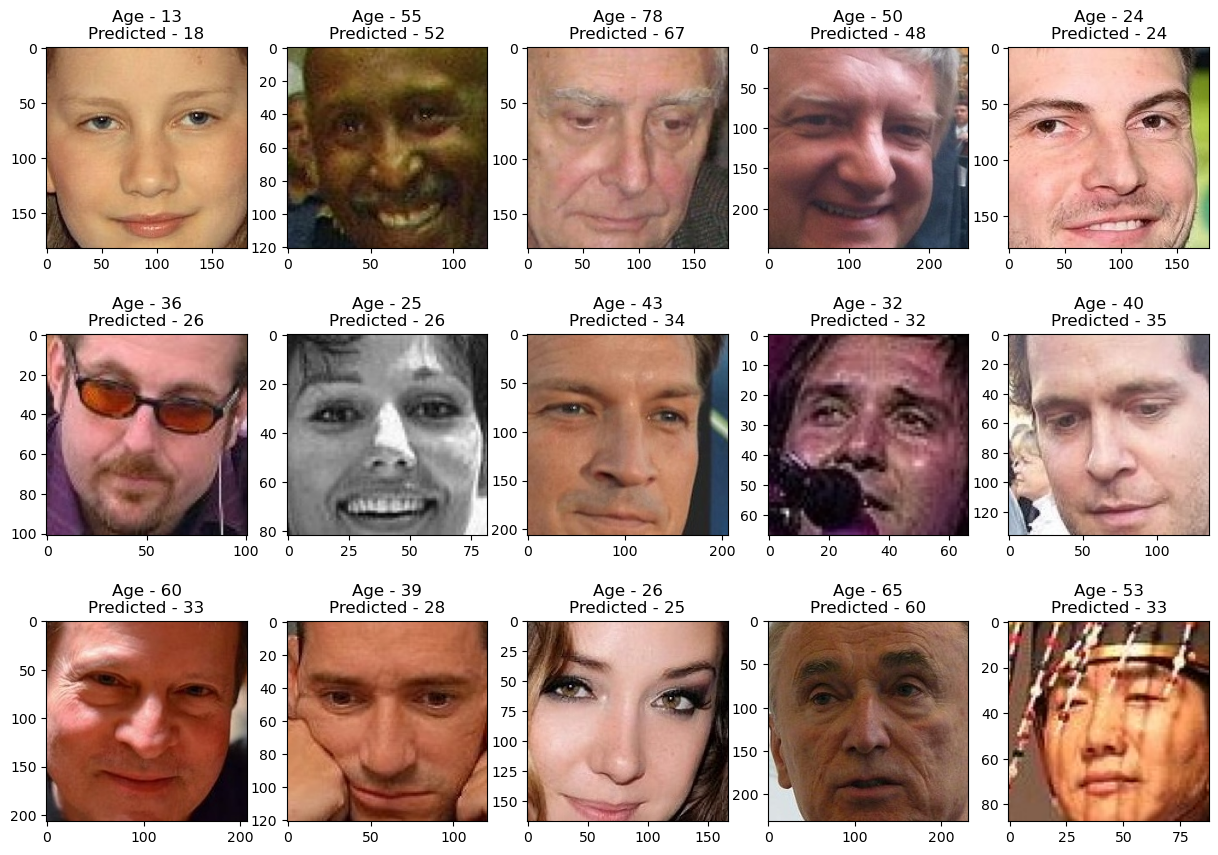

In [65]:
idx = np.random.randint (0,len(test),15)
plt.figure(figsize=(15,18))
for idx in enumerate(idx):
        plt.subplot (5,5,idx[0]+1)
        link = test.iloc[idx[1]]
        image = plt.imread(link[0])
      
        img_resized = cv2.resize (image, (64,64))/255
        img_reshaped  = img_resized.reshape (1,64,64,3)
        predict = all_model.predict(img_reshaped)[0][0]
    
        title = 'Age - ' + str(link[1]) + '\nPredicted - ' + str(int(predict))
        plt.title (title)
        plt.imshow(image, cmap='gray')